# First GOP Debate Twitter Sentiment

Analyze tweets on the first 2016 GOP Presidential Debate

We looked through tens of thousands of tweets about the early August GOP debate in Ohio and asked contributors to do sentiment analysis.

# Goals and objectives of the project

The goal of this project is to see if our machine learning model can accurately, to a large extent, predict if a sentiment will be positive or negative by just going through the tweets.

In [1]:
import numpy as np
import pandas as pd
import re
from nltk.stem.porter import PorterStemmer
import seaborn as sns
from wordcloud import WordCloud 
%matplotlib inline  
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


In [2]:
#Load Data

df = pd.read_csv("Sentiment.csv")
df.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,...,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,...,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,...,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,...,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,...,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


In [3]:
df.columns

Index(['id', 'candidate', 'candidate_confidence', 'relevant_yn',
       'relevant_yn_confidence', 'sentiment', 'sentiment_confidence',
       'subject_matter', 'subject_matter_confidence', 'candidate_gold', 'name',
       'relevant_yn_gold', 'retweet_count', 'sentiment_gold',
       'subject_matter_gold', 'text', 'tweet_coord', 'tweet_created',
       'tweet_id', 'tweet_location', 'user_timezone'],
      dtype='object')

## Feature Selection

We are keeping only those columns which are required for our model prepartion and deleting the other columns.


In [4]:
data = df[['text','sentiment']]
data.head()

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive


In [5]:
data['sentiment'].values

array(['Neutral', 'Positive', 'Neutral', ..., 'Positive', 'Negative',
       'Positive'], dtype=object)

In [6]:
#Drop columns which has neatral sentiment

data.drop(data[data.sentiment == 'Neutral'].index, inplace=True)

In [7]:
data['sentiment'].values

array(['Positive', 'Positive', 'Positive', ..., 'Positive', 'Negative',
       'Positive'], dtype=object)

In [8]:
data.count()

text         10729
sentiment    10729
dtype: int64

# Data Cleaning

In [9]:
# Checking for null values

data.isnull().sum()

text         0
sentiment    0
dtype: int64

In [10]:
data.sentiment.value_counts()

Negative    8493
Positive    2236
Name: sentiment, dtype: int64

In [11]:
# Checking for duplicate values

data.duplicated(subset=['text']).sum()

2945

In [12]:
# Dropping ALL duplicte values 

data.drop_duplicates(subset ="text", keep = False, inplace = True)

In [13]:
# After removing duplicates

data.duplicated(subset=['text']).sum()

0

## EDA

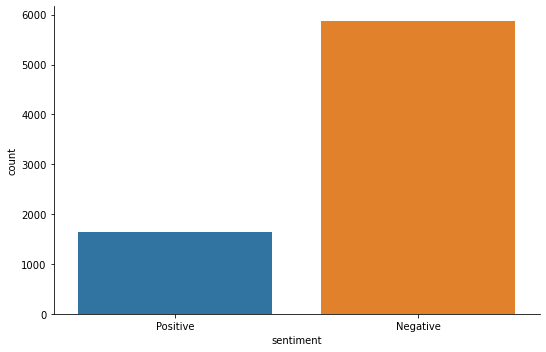

In [14]:
sns.factorplot(data=data,kind='count',size=5,aspect=1.5,x='sentiment')

In [15]:
data.sentiment.value_counts()

Negative    5872
Positive    1634
Name: sentiment, dtype: int64

# Preparing Dataset

Data often come from different sources and most of the time don’t come in the right format for the machine to process them. Hence, data cleaning is an important aspect of a data science project.

Hence, working with text data is more tricky that regular data and one of the reasons for that is because text may come in different forms with different combinations of both upper and lower cases, slangs, the use of symbols such as @, &; and so on. In text mining, we need to put the words in lowercase, remove stops words that do not add any meaning to the model etc.

In [16]:
# Converting to lower case

data['text'] = data['text'].str.lower()
data.head()

,text,sentiment
1,rt @scottwalker: didn't catch the full #gopdeb...,Positive
3,rt @robgeorge: that carly fiorina is trending ...,Positive
4,rt @danscavino: #gopdebate w/ @realdonaldtrump...,Positive
5,"rt @gregabbott_tx: @tedcruz: ""on my first day ...",Positive
6,rt @warriorwoman91: i liked her and was happy ...,Negative


In [17]:
# Removing Twitter Handles (@user)

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt 

data['text'] = np.vectorize(remove_pattern)(data['text'], "@[\w]*") 
data.head()

,text,sentiment
1,rt : didn't catch the full #gopdebate last nig...,Positive
3,rt : that carly fiorina is trending -- hours a...,Positive
4,rt : #gopdebate w/ delivered the highest rati...,Positive
5,"rt : : ""on my first day i will rescind every i...",Positive
6,rt : i liked her and was happy when i heard sh...,Negative


In [18]:
# Removing Punctuations, Numbers, and Special Characters
# Here we will replace everything except characters and hashtags with spaces. 

data['text'] = data['text'].str.replace("[^a-zA-z#]", " ") 
data.head()

,text,sentiment
1,rt didn t catch the full #gopdebate last nig...,Positive
3,rt that carly fiorina is trending hours a...,Positive
4,rt #gopdebate w delivered the highest rati...,Positive
5,rt on my first day i will rescind every i...,Positive
6,rt i liked her and was happy when i heard sh...,Negative


In [19]:
#Removing Short Words

data['text'] = data['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
data.head()

,text,sentiment
1,didn catch full #gopdebate last night here som...,Positive
3,that carly fiorina trending hours after debate...,Positive
4,#gopdebate delivered highest ratings history p...,Positive
5,first will rescind every illegal executive act...,Positive
6,liked happy when heard going moderator anymore...,Negative


In [20]:
# Stemming

stemmer = PorterStemmer()

def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

data['text'] = data["text"].apply(lambda text: stem_words(text))
data.head()

,text,sentiment
1,didn catch full #gopdeb last night here some s...,Positive
3,that carli fiorina trend hour after debat abov...,Positive
4,#gopdeb deliv highest rate histori presidenti ...,Positive
5,first will rescind everi illeg execut action t...,Positive
6,like happi when heard go moder anymor #gopdeb ...,Negative


# Process the data

Tokenize the data and convert the text to sequences. Add padding to ensure that all the sequences have the same shape. There are many ways of taking the max_len and here an arbitrary length of 150 is chosen.

In [21]:
#Get target data 

X = data.text
Le = LabelEncoder()
Y = Le.fit_transform(data['sentiment'])

In [22]:
# Split into training and test data.

X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size=0.20)

In [23]:
max_words = 3000
max_review_length = 150

# To give token to each word for first 3000 words in train data
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_review_length)

# Fit on test data
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_review_length)

In [24]:
# create the model

embedding_vecor_length = 32

model = Sequential()

model.add(Embedding(max_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 32)           96032     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 120,929
Trainable params: 120,929
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
# Train the LSTM model 

model.fit(sequences_matrix, Y_train, epochs=10, batch_size=64)

Epoch 1/10
94/94 [==============================] - 21s 220ms/step - loss: 0.5386 - accuracy: 0.7815
Epoch 2/10
94/94 [==============================] - 20s 216ms/step - loss: 0.4525 - accuracy: 0.7965
Epoch 3/10
94/94 [==============================] - 20s 216ms/step - loss: 0.3527 - accuracy: 0.8481
Epoch 4/10
94/94 [==============================] - 23s 241ms/step - loss: 0.2986 - accuracy: 0.8746
Epoch 5/10
94/94 [==============================] - 22s 234ms/step - loss: 0.2724 - accuracy: 0.8811
Epoch 6/10
94/94 [==============================] - 23s 239ms/step - loss: 0.2537 - accuracy: 0.8921
Epoch 7/10
94/94 [==============================] - 21s 227ms/step - loss: 0.2345 - accuracy: 0.8964
Epoch 8/10
94/94 [==============================] - 21s 221ms/step - loss: 0.2147 - accuracy: 0.9031
Epoch 9/10
94/94 [==============================] - 21s 224ms/step - loss: 0.2027 - accuracy: 0.9134
Epoch 10/10
94/94 [==============================] - 21s 226ms/step - loss: 0.2001 - accura

# Evaluate the model on the test set.


In [26]:
# Predict on test data

accr = model.evaluate(test_sequences_matrix,Y_test)

47/47 [==============================] - 1s 24ms/step - loss: 0.5689 - accuracy: 0.7969
